In [ ]:
!pip install torch torchvision
!pip install lion-pytorch

import os
import math
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    confusion_matrix, matthews_corrcoef, cohen_kappa_score,
    log_loss, roc_auc_score
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lion_pytorch import Lion

# **NeuroTab**

In [ ]:
class GLULayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0.1):
        super(GLULayer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim * 2)
        self.bn = nn.BatchNorm1d(output_dim * 2)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x_proj = self.fc(x)
        x_proj = self.bn(x_proj)
        x1, x2 = x_proj.chunk(2, dim=-1)
        x_glu = x1 * torch.sigmoid(x2)
        x_glu = self.dropout(x_glu)
        return x_glu

class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, n_glu_layers, shared_layers=None, dropout=0.1):
        super().__init__()
        self.shared = shared_layers
        self.blocks = nn.ModuleList()
        if input_dim != output_dim:
            self.initial_layer = GLULayer(input_dim, output_dim, dropout)
        else:
            self.initial_layer = None
        for i in range(n_glu_layers):
            self.blocks.append(GLULayer(output_dim, output_dim, dropout))
    def forward(self, x):
        if self.initial_layer is not None:
            x = self.initial_layer(x)
        if self.shared is not None and x.size(1) == self.shared[0].fc.out_features // 2:
            for layer in self.shared:
                residual = x
                x = layer(x)
                if residual.shape == x.shape:
                    x = (x + residual) * math.sqrt(0.5)
        for layer in self.blocks:
            residual = x
            x = layer(x)
            if residual.shape == x.shape:
                x = (x + residual) * math.sqrt(0.5)
        return x

class Sparsemax(nn.Module):
    def forward(self, input):
        input = input - input.max(dim=1, keepdim=True)[0]
        z_sorted, _ = torch.sort(input, dim=1, descending=True)
        k = torch.arange(1, input.size(1)+1, device=input.device).float()
        z_cumsum = torch.cumsum(z_sorted, dim=1)
        k_mask = 1 + k * z_sorted > z_cumsum
        k_max = torch.clamp(k_mask.sum(dim=1, keepdim=True), min=1)
        tau_sum = torch.gather(z_cumsum, 1, k_max.long() - 1)
        tau = (tau_sum - 1) / k_max
        output = torch.clamp(input - tau, min=0)
        return output

class AttentiveTransformer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AttentiveTransformer, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.sparsemax = Sparsemax()
    def forward(self, x, prior):
        x = self.fc(x)
        x = self.bn(x)
        x = x * prior
        x = self.sparsemax(x)
        return x

class DecisionStep(nn.Module):
    def __init__(self, input_dim, feature_dim, output_dim, shared_layers=None, n_glu=2, gamma=1.3, dropout=0.1):
        super().__init__()
        self.gamma=gamma
        self.attentive_transformer = AttentiveTransformer(
            input_dim=feature_dim // 2,
            output_dim=input_dim
        )
        self.feature_transformer = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_glu,
            shared_layers=shared_layers,
            dropout=dropout
        )
        self.n_d = feature_dim // 2
        self.n_a = feature_dim - self.n_d
    def forward(self, a_prev, prior, x_o):
        mask = self.attentive_transformer(a_prev, prior)
        masked_x = x_o * mask
        ft_output = self.feature_transformer(masked_x)
        d_i = ft_output[:, :self.n_d]
        a_i = ft_output[:, self.n_d:]
        d_i = F.relu(d_i)
        prior_next = prior * (self.gamma - mask)
        return d_i, a_i, mask, prior_next

class CustomTabNetEncoder(nn.Module):
    def __init__(self, input_dim=19, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, dropout=0.1):
        super().__init__()
        self.n_steps = n_steps
        self.gamma = gamma
        self.input_dim = input_dim
        self.feature_dim = feature_dim
        self.shared_layers = nn.ModuleList()
        for i in range(n_shared):
            self.shared_layers.append(GLULayer(feature_dim, feature_dim, dropout))
        self.initial_transform = FeatureTransformer(
            input_dim=input_dim,
            output_dim=feature_dim,
            n_glu_layers=n_shared + n_independent,
            shared_layers=None,
            dropout=dropout
        )
        self.decision_steps = nn.ModuleList([
            DecisionStep(
                input_dim=input_dim,
                feature_dim=feature_dim,
                output_dim=feature_dim,
                shared_layers=self.shared_layers,
                n_glu=n_glu,
                dropout=dropout
            )
            for _ in range(n_steps)
        ])
        for step in self.decision_steps:
            step.gamma = gamma
        self.bn = nn.BatchNorm1d(input_dim)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        x_o = self.bn(x)
        prior = torch.ones_like(x_o)
        initial_output = self.initial_transform(x_o)
        n_d = self.feature_dim // 2
        d0 = initial_output[:, :n_d]
        a0 = initial_output[:, n_d:]
        decision_outputs = []
        a_prev = a0
        for step in self.decision_steps:
            d_i, a_i, mask, prior = step(a_prev, prior, x_o)
            decision_outputs.append(d_i)
            a_prev = a_i
        aggregated = torch.stack(decision_outputs, dim=0).sum(dim=0)

        return aggregated

class CustomTabNetClassifier(nn.Module):
    def __init__(self, input_dim=19, feature_dim=96, n_steps=3, gamma=1.3,
                 n_glu=2, n_shared=2, n_independent=2, num_classes=3, dropout=0.1):
        super(CustomTabNetClassifier, self).__init__()
        self.encoder = CustomTabNetEncoder(
            input_dim=input_dim,
            feature_dim=feature_dim,
            n_steps=n_steps,
            gamma=gamma,
            n_glu=n_glu,
            n_shared=n_shared,
            n_independent=n_independent,
            dropout=dropout
        )
        self.head = nn.Linear(feature_dim // 2, num_classes)
        self._initialize_weights()
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    def forward(self, x):
        encoded = self.encoder(x)
        return self.head(encoded)

df = pd.read_csv('/content/drive/MyDrive/NeuroTab/Headache/Final_merged_headache.csv')
X = df.drop(columns=["CLASS"])
y = df["CLASS"]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=1/3, stratify=y_test, random_state=42
)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, drop_last=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, drop_last=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X.shape[1]
print(f"Input dimension: {input_dim}")

model = CustomTabNetClassifier(
    input_dim=input_dim,
    feature_dim=96,
    n_steps=3,
    gamma=1.3,
    n_glu=2,
    n_shared=2,
    n_independent=2,
    num_classes=len(np.unique(y)),
    dropout=0.1
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    sample_count = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return correct / total, total_loss / sample_count
def train(model, train_loader, val_loader, scheduler, epochs=100, patience=20):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
        train_acc = correct / total
        train_loss = total_loss / len(train_loader)
        val_acc, val_loss = evaluate(model, val_loader)
        scheduler.step(val_acc)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"Epoch {epoch+1:02d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, LR={optimizer.param_groups[0]['lr']:.6f}")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered!")
                break
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")
    return history
history = train(model, train_loader, val_loader, scheduler, epochs=100, patience=20)
def get_all_preds(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    return np.array(y_true), np.array(y_pred), np.array(y_prob)

y_test_true, y_test_pred, y_test_prob = get_all_preds(model, test_loader)

train_acc, train_loss = evaluate(model, train_loader)
val_acc, val_loss = evaluate(model, val_loader)
test_acc, test_loss = evaluate(model, test_loader)

precision = precision_score(y_test_true, y_test_pred, average='macro', zero_division=0)
recall = recall_score(y_test_true, y_test_pred, average='macro')
f1 = f1_score(y_test_true, y_test_pred, average='macro')
conf_matrix = confusion_matrix(y_test_true, y_test_pred)
mcc = matthews_corrcoef(y_test_true, y_test_pred)
cohen_kappa = cohen_kappa_score(y_test_true, y_test_pred)
logloss = log_loss(y_test_true, y_test_prob)

y_bin = label_binarize(y_test_true, classes=np.arange(y_test_prob.shape[1]))
auroc = roc_auc_score(y_bin, y_test_prob, average='macro', multi_class='ovr')

print(f"Training Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}, Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Sensitivity (Recall): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Matthews Corr Coef: {mcc:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Macro-Averaged AUROC (OvR): {auroc:.4f}")

Input dimension: 19
Epoch 01: Train Loss = 0.7804, Train Acc = 0.6613, Val Loss = 0.6379, Val Acc = 0.8328, LR = 0.001000
Epoch 02: Train Loss = 0.2342, Train Acc = 0.9219, Val Loss = 0.0897, Val Acc = 0.9707, LR = 0.001000
Epoch 03: Train Loss = 0.1433, Train Acc = 0.9627, Val Loss = 0.0739, Val Acc = 0.9776, LR = 0.001000
Epoch 04: Train Loss = 0.0981, Train Acc = 0.9708, Val Loss = 0.0592, Val Acc = 0.9810, LR = 0.001000
Epoch 05: Train Loss = 0.0825, Train Acc = 0.9783, Val Loss = 0.0563, Val Acc = 0.9793, LR = 0.001000
Epoch 06: Train Loss = 0.0763, Train Acc = 0.9768, Val Loss = 0.0421, Val Acc = 0.9828, LR = 0.001000
Epoch 07: Train Loss = 0.0614, Train Acc = 0.9773, Val Loss = 0.0365, Val Acc = 0.9828, LR = 0.001000
Epoch 08: Train Loss = 0.0414, Train Acc = 0.9869, Val Loss = 0.0466, Val Acc = 0.9793, LR = 0.001000
Epoch 09: Train Loss = 0.0488, Train Acc = 0.9819, Val Loss = 0.0262, Val Acc = 0.9914, LR = 0.001000
Epoch 10: Train Loss = 0.0409, Train Acc = 0.9859, Val Loss = 

In [ ]:
import torch
import pickle
from sklearn.preprocessing import StandardScaler
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': input_dim,
        'feature_dim': 96,
        'n_steps': 3,
        'gamma': 1.3,
        'n_glu': 2,
        'n_shared': 2,
        'n_independent': 2,
        'num_classes': 3,
        'dropout': 0.1
    }
}, '/content/drive/MyDrive/NeuroTab/Headache/NeuroTab_headache_model.pth')
with open('/content/drive/MyDrive/NeuroTab/Headache/NeuroTab_headache_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

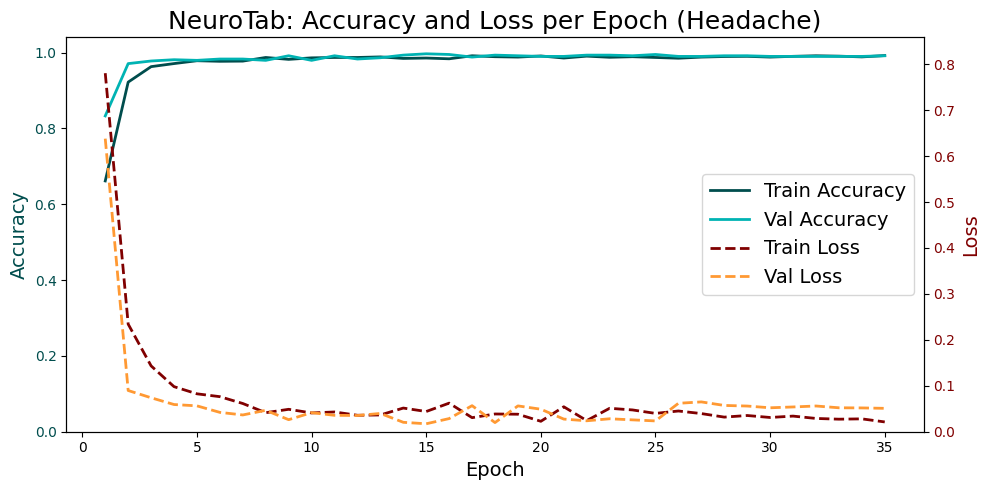

In [ ]:
epochs = range(1, len(history['train_acc']) + 1)
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Epoch', fontsize=14)
ax1.plot(epochs, history['train_acc'], label='Train Accuracy', color='#004d4d', linewidth=2, linestyle='-')
ax1.plot(epochs, history['val_acc'], label='Val Accuracy', color='#00b3b3', linewidth=2, linestyle='-')
ax1.set_ylabel('Accuracy', color='#004d4d', fontsize=14)
ax1.tick_params(axis='y', labelcolor='#004d4d')
ax1.set_ylim(0, 1.04)

ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='#800000', fontsize=14)
ax2.plot(epochs, history['train_loss'], label='Train Loss', color='#800000', linewidth=2, linestyle='--')
ax2.plot(epochs, history['val_loss'], label='Val Loss', color='#ff9933', linewidth=2, linestyle='--')
ax2.tick_params(axis='y', labelcolor='#800000')
ax2.set_ylim(0, max(max(history['train_loss']), max(history['val_loss'])) * 1.1)

plt.title('NeuroTab: Accuracy and Loss per Epoch (Headache)', fontsize=18)
fig.tight_layout()
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=14)
plt.grid(False)
plt.show()

Classification Report:
              precision    recall  f1-score   support

    Migraine       0.99      1.00      1.00       103
     Cluster       1.00      0.99      0.99        90
     Tension       0.99      0.99      0.99        97

    accuracy                           0.99       290
   macro avg       0.99      0.99      0.99       290
weighted avg       0.99      0.99      0.99       290



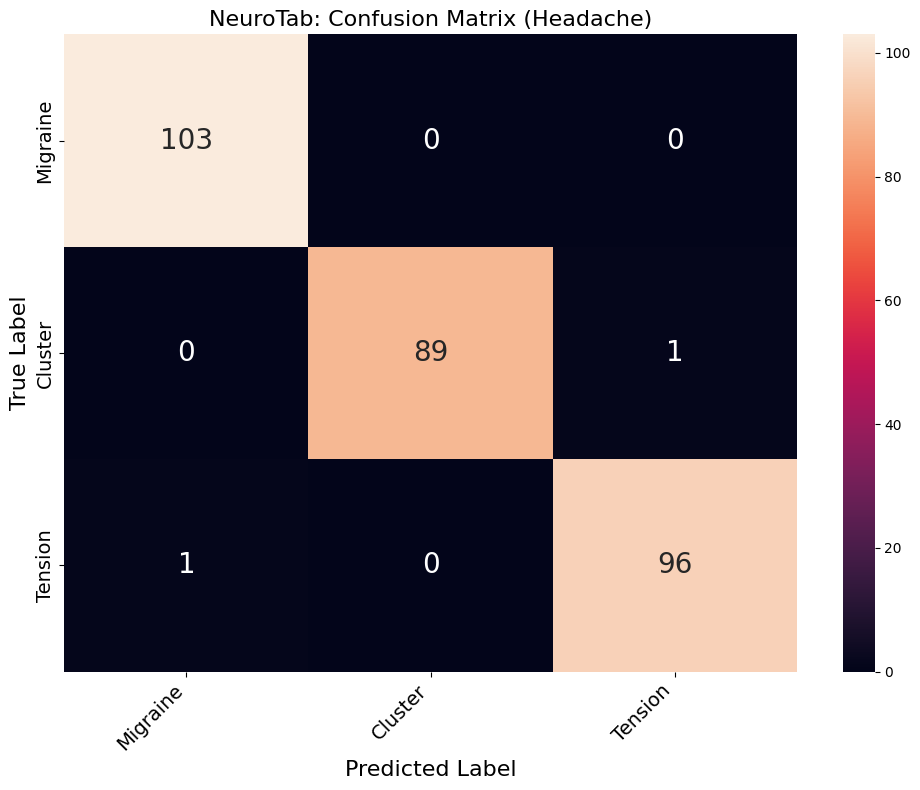

In [ ]:
def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_predictions(model, test_loader)
cm = confusion_matrix(y_true, y_pred)
class_names = [

    "Migraine",
    "Cluster",
    "Tension",
]
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 20}
)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.title("NeuroTab: Confusion Matrix (Headache)", fontsize=16)
plt.xticks(fontsize=14, rotation=45, ha='right')
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# **StratifiedKFold**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    cohen_kappa_score, matthews_corrcoef,
    hamming_loss, jaccard_score
)
from lion_pytorch import Lion

# k=5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model, loader, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += batch_size
    model.train()
    return correct / total, total_loss / total

def run_stratified_kfold(X, y, k=5, epochs=100, batch_size=64, patience=20, identifier="k_5"):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\n====== Fold {fold+1} ======")

        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42
        )

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=batch_size, shuffle=True, drop_last=True
        )
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size, shuffle=False
        )
        test_loader = DataLoader(
            TensorDataset(X_test_tensor, y_test_tensor),
            batch_size=batch_size, shuffle=False
        )

        model = CustomTabNetClassifier(
            input_dim=input_dim,
            feature_dim=96,
            n_steps=3,
            gamma=1.3,
            n_glu=2,
            n_shared=2,
            n_independent=2,
            num_classes=3,
            dropout=0.1
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )
        best_val_acc = 0.0
        best_model_state = None
        epochs_without_improvement = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            model.train()
            total_loss = 0.0
            correct = 0
            total = 0

            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * xb.size(0)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

            train_loss = total_loss / total
            train_acc = correct / total

            val_acc, val_loss = evaluate(model, val_loader, criterion)
            scheduler.step(val_acc)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    break

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        model.eval()
        test_correct = 0
        test_total = 0
        all_preds = []
        all_true = []
        test_loss_total = 0

        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                test_loss_total += loss.item() * xb.size(0)
                test_correct += (preds.argmax(1) == yb).sum().item()
                test_total += yb.size(0)
                all_preds.extend(preds.argmax(1).cpu().numpy())
                all_true.extend(yb.cpu().numpy())

        test_acc = test_correct / test_total
        test_loss = test_loss_total / test_total
        test_f1 = f1_score(all_true, all_preds, average='macro')
        test_precision = precision_score(all_true, all_preds, average='macro')
        test_recall = recall_score(all_true, all_preds, average='macro')
        test_kappa = cohen_kappa_score(all_true, all_preds)
        test_mcc = matthews_corrcoef(all_true, all_preds)
        test_hamming = hamming_loss(all_true, all_preds)
        test_jaccard = jaccard_score(all_true, all_preds, average='macro')

        print(f"Fold {fold+1} - Test Acc: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}")
        print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Kappa: {test_kappa:.4f}, MCC: {test_mcc:.4f}")
        print(f"Hamming: {test_hamming:.4f}, Jaccard: {test_jaccard:.4f}")

        fold_metrics.append({
            'fold': fold + 1,
            'identifier': identifier,
            'history': history,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_kappa': test_kappa,
            'test_mcc': test_mcc,
            'test_hamming': test_hamming,
            'test_jaccard': test_jaccard,
            'y_true': all_true,
            'y_pred': all_preds
        })

    return fold_metrics

X_np = X_scaled.astype(np.float32)
y_np = y.values.astype(np.int64)

stratified_results_k_5 = run_stratified_kfold(
    X_np, y_np, k=5, epochs=100, batch_size=64, identifier="k_5"
)
test_accs = [fold['test_acc'] for fold in stratified_results_k_5]
test_f1s = [fold['test_f1'] for fold in stratified_results_k_5]
test_losses = [fold['test_loss'] for fold in stratified_results_k_5]
test_precisions = [fold['test_precision'] for fold in stratified_results_k_5]
test_recalls = [fold['test_recall'] for fold in stratified_results_k_5]
test_kappas = [fold['test_kappa'] for fold in stratified_results_k_5]
test_mccs = [fold['test_mcc'] for fold in stratified_results_k_5]
test_hammings = [fold['test_hamming'] for fold in stratified_results_k_5]
test_jaccards = [fold['test_jaccard'] for fold in stratified_results_k_5]

print(f"\n=== Cross-Validation Summary for k=5 ===")
print(f"Average Test Accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"Average Test F1 Score (Macro): {np.mean(test_f1s):.4f} ± {np.std(test_f1s):.4f}")
print(f"Average Test Loss: {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
print(f"Average Precision (Macro): {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Average Recall (Macro): {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")
print(f"Average Cohen's Kappa: {np.mean(test_kappas):.4f} ± {np.std(test_kappas):.4f}")
print(f"Average MCC: {np.mean(test_mccs):.4f} ± {np.std(test_mccs):.4f}")
print(f"Average Hamming Loss: {np.mean(test_hammings):.4f} ± {np.std(test_hammings):.4f}")
print(f"Average Jaccard Score (Macro): {np.mean(test_jaccards):.4f} ± {np.std(test_jaccards):.4f}")


====== Fold 1 ======
Epoch 001 | Train Loss: 0.7946 Acc: 0.6641 | Val Loss: 0.6604 Acc: 0.8132
Epoch 002 | Train Loss: 0.2227 Acc: 0.9250 | Val Loss: 0.1294 Acc: 0.9684
Epoch 003 | Train Loss: 0.1139 Acc: 0.9620 | Val Loss: 0.0775 Acc: 0.9741
Epoch 004 | Train Loss: 0.0744 Acc: 0.9755 | Val Loss: 0.0639 Acc: 0.9770
Epoch 005 | Train Loss: 0.0792 Acc: 0.9750 | Val Loss: 0.0679 Acc: 0.9828
Epoch 006 | Train Loss: 0.0476 Acc: 0.9859 | Val Loss: 0.0978 Acc: 0.9799
Epoch 007 | Train Loss: 0.0664 Acc: 0.9781 | Val Loss: 0.0626 Acc: 0.9856
Epoch 008 | Train Loss: 0.0587 Acc: 0.9823 | Val Loss: 0.0557 Acc: 0.9856
Epoch 009 | Train Loss: 0.0507 Acc: 0.9807 | Val Loss: 0.0672 Acc: 0.9770
Epoch 010 | Train Loss: 0.0491 Acc: 0.9828 | Val Loss: 0.1024 Acc: 0.9626
Epoch 011 | Train Loss: 0.0570 Acc: 0.9786 | Val Loss: 0.0751 Acc: 0.9799
Epoch 012 | Train Loss: 0.0490 Acc: 0.9859 | Val Loss: 0.0769 Acc: 0.9770
Epoch 013 | Train Loss: 0.0410 Acc: 0.9891 | Val Loss: 0.0612 Acc: 0.9770
Epoch 014 | Trai

# k=10

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    cohen_kappa_score, matthews_corrcoef,
    hamming_loss, jaccard_score
)
from lion_pytorch import Lion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model, loader, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += batch_size
    model.train()
    return correct / total, total_loss / total

def run_stratified_kfold(X, y, k=10, epochs=100, batch_size=64, patience=20, identifier="k_10"):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_val_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\n====== Fold {fold+1} ======")

        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42
        )

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        train_loader = DataLoader(
            TensorDataset(X_train_tensor, y_train_tensor),
            batch_size=batch_size, shuffle=True, drop_last=True
        )
        val_loader = DataLoader(
            TensorDataset(X_val_tensor, y_val_tensor),
            batch_size=batch_size, shuffle=False
        )
        test_loader = DataLoader(
            TensorDataset(X_test_tensor, y_test_tensor),
            batch_size=batch_size, shuffle=False
        )

        model = CustomTabNetClassifier(
            input_dim=input_dim,
            feature_dim=96,
            n_steps=3,
            gamma=1.3,
            n_glu=2,
            n_shared=2,
            n_independent=2,
            num_classes=3,
            dropout=0.1
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='max', factor=0.5, patience=5
        )

        best_val_acc = 0.0
        best_model_state = None
        epochs_without_improvement = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            model.train()
            total_loss = 0.0
            correct = 0
            total = 0

            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * xb.size(0)
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

            train_loss = total_loss / total
            train_acc = correct / total

            val_acc, val_loss = evaluate(model, val_loader, criterion)
            scheduler.step(val_acc)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    break

        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        model.eval()
        test_correct = 0
        test_total = 0
        all_preds = []
        all_true = []
        test_loss_total = 0

        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                test_loss_total += loss.item() * xb.size(0)
                test_correct += (preds.argmax(1) == yb).sum().item()
                test_total += xb.size(0)
                all_preds.extend(preds.argmax(1).cpu().numpy())
                all_true.extend(yb.cpu().numpy())

        test_acc = test_correct / test_total
        test_loss = test_loss_total / test_total

        test_f1 = f1_score(all_true, all_preds, average='macro')
        test_precision = precision_score(all_true, all_preds, average='macro')
        test_recall = recall_score(all_true, all_preds, average='macro')
        test_kappa = cohen_kappa_score(all_true, all_preds)
        test_mcc = matthews_corrcoef(all_true, all_preds)
        test_hamming = hamming_loss(all_true, all_preds)
        test_jaccard = jaccard_score(all_true, all_preds, average='macro')

        print(f"Fold {fold+1} - Test Acc: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}")
        print(f"             Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Kappa: {test_kappa:.4f}, MCC: {test_mcc:.4f}")
        print(f"             Hamming: {test_hamming:.4f}, Jaccard: {test_jaccard:.4f}")

        fold_metrics.append({
            'fold': fold + 1,
            'identifier': identifier,
            'history': history,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_kappa': test_kappa,
            'test_mcc': test_mcc,
            'test_hamming': test_hamming,
            'test_jaccard': test_jaccard,
            'y_true': all_true,
            'y_pred': all_preds
        })

    return fold_metrics

X_np = X_scaled.astype(np.float32)
y_np = y.values.astype(np.int64)

stratified_results_k_10 = run_stratified_kfold(
    X_np, y_np, k=10, epochs=100, batch_size=64, identifier="k_10"
)

test_accs = [fold['test_acc'] for fold in stratified_results_k_10]
test_f1s = [fold['test_f1'] for fold in stratified_results_k_10]
test_losses = [fold['test_loss'] for fold in stratified_results_k_10]
test_precisions = [fold['test_precision'] for fold in stratified_results_k_10]
test_recalls = [fold['test_recall'] for fold in stratified_results_k_10]
test_kappas = [fold['test_kappa'] for fold in stratified_results_k_10]
test_mccs = [fold['test_mcc'] for fold in stratified_results_k_10]
test_hammings = [fold['test_hamming'] for fold in stratified_results_k_10]
test_jaccards = [fold['test_jaccard'] for fold in stratified_results_k_10]

print(f"\n=== Cross-Validation Summary for k=10 ===")
print(f"Average Test Accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"Average Test F1 Score (Macro): {np.mean(test_f1s):.4f} ± {np.std(test_f1s):.4f}")
print(f"Average Test Loss: {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
print(f"Average Precision (Macro): {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Average Recall (Macro): {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")
print(f"Average Cohen's Kappa: {np.mean(test_kappas):.4f} ± {np.std(test_kappas):.4f}")
print(f"Average MCC: {np.mean(test_mccs):.4f} ± {np.std(test_mccs):.4f}")
print(f"Average Hamming Loss: {np.mean(test_hammings):.4f} ± {np.std(test_hammings):.4f}")
print(f"Average Jaccard Score (Macro): {np.mean(test_jaccards):.4f} ± {np.std(test_jaccards):.4f}")


====== Fold 1 ======
Epoch 001 | Train Loss: 0.6216 Acc: 0.7734 | Val Loss: 0.3690 Acc: 0.9464
Epoch 002 | Train Loss: 0.1810 Acc: 0.9444 | Val Loss: 0.0659 Acc: 0.9872
Epoch 003 | Train Loss: 0.0970 Acc: 0.9720 | Val Loss: 0.0404 Acc: 0.9821
Epoch 004 | Train Loss: 0.0803 Acc: 0.9761 | Val Loss: 0.0449 Acc: 0.9847
Epoch 005 | Train Loss: 0.0798 Acc: 0.9770 | Val Loss: 0.0547 Acc: 0.9872
Epoch 006 | Train Loss: 0.0812 Acc: 0.9816 | Val Loss: 0.0388 Acc: 0.9898
Epoch 007 | Train Loss: 0.0666 Acc: 0.9812 | Val Loss: 0.0455 Acc: 0.9847
Epoch 008 | Train Loss: 0.0703 Acc: 0.9775 | Val Loss: 0.0430 Acc: 0.9872
Epoch 009 | Train Loss: 0.0549 Acc: 0.9812 | Val Loss: 0.0355 Acc: 0.9898
Epoch 010 | Train Loss: 0.0531 Acc: 0.9821 | Val Loss: 0.0301 Acc: 0.9898
Epoch 011 | Train Loss: 0.0424 Acc: 0.9890 | Val Loss: 0.0228 Acc: 0.9923
Epoch 012 | Train Loss: 0.0462 Acc: 0.9844 | Val Loss: 0.0233 Acc: 0.9923
Epoch 013 | Train Loss: 0.0407 Acc: 0.9844 | Val Loss: 0.0584 Acc: 0.9898
Epoch 014 | Trai

# **K-FOLD**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    cohen_kappa_score, matthews_corrcoef,
    hamming_loss, jaccard_score
)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from lion_pytorch import Lion

# K=5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model, loader, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss, sample_count = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return correct / total, total_loss / sample_count

def run_kfold(X, y, k=5, epochs=100, batch_size=64, patience=20):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_val_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\n====== Fold {fold+1} ======")

        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42
        )
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

        model = CustomTabNetClassifier(
            input_dim=input_dim,
            feature_dim=96,
            n_steps=3,
            gamma=1.3,
            n_glu=2,
            n_shared=2,
            n_independent=2,
            num_classes=3,
            dropout=0.1
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

        best_val_acc = 0.0
        best_model_state = None
        epochs_without_improvement = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            model.train()
            total_loss, correct, total = 0.0, 0, 0

            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

            train_acc = correct / total
            train_loss = total_loss / len(train_loader)
            val_acc, val_loss = evaluate(model, val_loader, criterion)
            scheduler.step(val_acc)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    break

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        test_correct, all_preds, all_true = 0, [], []
        test_loss_total = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                test_loss_total += loss.item()
                test_correct += (preds.argmax(1) == yb).sum().item()
                all_preds.extend(preds.argmax(1).cpu().numpy())
                all_true.extend(yb.cpu().numpy())

        test_acc = test_correct / len(all_true)
        test_loss = test_loss_total / len(test_loader)

        test_f1 = f1_score(all_true, all_preds, average='macro')
        test_precision = precision_score(all_true, all_preds, average='macro')
        test_recall = recall_score(all_true, all_preds, average='macro')
        test_kappa = cohen_kappa_score(all_true, all_preds)
        test_mcc = matthews_corrcoef(all_true, all_preds)
        test_hamming = hamming_loss(all_true, all_preds)
        test_jaccard = jaccard_score(all_true, all_preds, average='macro')

        print(f"Fold {fold+1} - Test Acc: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}")
        print(f"             Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Kappa: {test_kappa:.4f}, MCC: {test_mcc:.4f}")
        print(f"             Hamming: {test_hamming:.4f}, Jaccard: {test_jaccard:.4f}")

        fold_metrics.append({
            'fold': fold + 1,
            'history': history,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_kappa': test_kappa,
            'test_mcc': test_mcc,
            'test_hamming': test_hamming,
            'test_jaccard': test_jaccard,
            'y_true': all_true,
            'y_pred': all_preds
        })

    return fold_metrics

X_np = X_scaled.astype(np.float32)
y_np = y.values.astype(np.int64)
k = 5

kfold_results_k_5 = run_kfold(X_np, y_np, k=k, epochs=100)

test_accs = [fold['test_acc'] for fold in kfold_results_k_5]
test_losses = [fold['test_loss'] for fold in kfold_results_k_5]
test_f1s = [fold['test_f1'] for fold in kfold_results_k_5]
test_precisions = [fold['test_precision'] for fold in kfold_results_k_5]
test_recalls = [fold['test_recall'] for fold in kfold_results_k_5]
test_kappas = [fold['test_kappa'] for fold in kfold_results_k_5]
test_mccs = [fold['test_mcc'] for fold in kfold_results_k_5]
test_hammings = [fold['test_hamming'] for fold in kfold_results_k_5]
test_jaccards = [fold['test_jaccard'] for fold in kfold_results_k_5]

print(f"\n=== Cross-Validation Summary (K={k}) ===")
print(f"Average Test Accuracy:        {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"Average Test Loss:            {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
print(f"Average Test F1 Score (Macro):{np.mean(test_f1s):.4f} ± {np.std(test_f1s):.4f}")
print(f"Average Precision (Macro):    {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Average Recall (Macro):       {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")
print(f"Average Cohen's Kappa:        {np.mean(test_kappas):.4f} ± {np.std(test_kappas):.4f}")
print(f"Average MCC:                  {np.mean(test_mccs):.4f} ± {np.std(test_mccs):.4f}")
print(f"Average Hamming Loss:         {np.mean(test_hammings):.4f} ± {np.std(test_hammings):.4f}")
print(f"Average Jaccard Score (Macro):{np.mean(test_jaccards):.4f} ± {np.std(test_jaccards):.4f}")


====== Fold 1 ======
Epoch 001 | Train Loss: 0.7550 Acc: 0.7152 | Val Loss: 0.6147 Acc: 0.9454
Epoch 002 | Train Loss: 0.1856 Acc: 0.9401 | Val Loss: 0.0664 Acc: 0.9770
Epoch 003 | Train Loss: 0.1284 Acc: 0.9614 | Val Loss: 0.0287 Acc: 0.9914
Epoch 004 | Train Loss: 0.1033 Acc: 0.9685 | Val Loss: 0.0484 Acc: 0.9828
Epoch 005 | Train Loss: 0.0614 Acc: 0.9797 | Val Loss: 0.0507 Acc: 0.9914
Epoch 006 | Train Loss: 0.0802 Acc: 0.9761 | Val Loss: 0.0348 Acc: 0.9885
Epoch 007 | Train Loss: 0.0527 Acc: 0.9838 | Val Loss: 0.0189 Acc: 0.9914
Epoch 008 | Train Loss: 0.0864 Acc: 0.9807 | Val Loss: 0.0312 Acc: 0.9885
Epoch 009 | Train Loss: 0.0520 Acc: 0.9838 | Val Loss: 0.0444 Acc: 0.9885
Epoch 010 | Train Loss: 0.0537 Acc: 0.9822 | Val Loss: 0.0382 Acc: 0.9885
Epoch 011 | Train Loss: 0.0462 Acc: 0.9838 | Val Loss: 0.0565 Acc: 0.9770
Epoch 012 | Train Loss: 0.0458 Acc: 0.9868 | Val Loss: 0.0864 Acc: 0.9770
Epoch 013 | Train Loss: 0.0352 Acc: 0.9893 | Val Loss: 0.0455 Acc: 0.9828
Epoch 014 | Trai

# K=10

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate(model, loader, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss, sample_count = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            sample_count += batch_size
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    model.train()
    return correct / total, total_loss / sample_count

def run_kfold(X, y, k=10, epochs=100, batch_size=64, patience=20):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_val_idx, test_idx) in enumerate(kf.split(X)):
        print(f"\n====== Fold {fold+1} ======")

        X_train_val, X_test = X[train_val_idx], X[test_idx]
        y_train_val, y_test = y[train_val_idx], y[test_idx]

        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.15, stratify=y_train_val, random_state=42
        )

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)
        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
        test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

        model = CustomTabNetClassifier(
            input_dim=input_dim,
            feature_dim=96,
            n_steps=3,
            gamma=1.3,
            n_glu=2,
            n_shared=2,
            n_independent=2,
            num_classes=7,
            dropout=0.1
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Lion(model.parameters(), lr=1e-3, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

        best_val_acc = 0.0
        best_model_state = None
        epochs_without_improvement = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        for epoch in range(epochs):
            model.train()
            total_loss, correct, total = 0.0, 0, 0

            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)

                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct += (preds.argmax(1) == yb).sum().item()
                total += yb.size(0)

            train_acc = correct / total
            train_loss = total_loss / len(train_loader)
            val_acc, val_loss = evaluate(model, val_loader, criterion)
            scheduler.step(val_acc)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict()
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    break

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        test_correct, all_preds, all_true = 0, [], []
        test_loss_total = 0.0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                test_loss_total += loss.item()
                test_correct += (preds.argmax(1) == yb).sum().item()
                all_preds.extend(preds.argmax(1).cpu().numpy())
                all_true.extend(yb.cpu().numpy())

        test_acc = test_correct / len(all_true)
        test_loss = test_loss_total / len(test_loader)

        test_f1 = f1_score(all_true, all_preds, average='macro')
        test_precision = precision_score(all_true, all_preds, average='macro')
        test_recall = recall_score(all_true, all_preds, average='macro')
        test_kappa = cohen_kappa_score(all_true, all_preds)
        test_mcc = matthews_corrcoef(all_true, all_preds)
        test_hamming = hamming_loss(all_true, all_preds)
        test_jaccard = jaccard_score(all_true, all_preds, average='macro')

        print(f"Fold {fold+1} - Test Acc: {test_acc:.4f}, Loss: {test_loss:.4f}, F1: {test_f1:.4f}")
        print(f"             Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, Kappa: {test_kappa:.4f}, MCC: {test_mcc:.4f}")
        print(f"             Hamming: {test_hamming:.4f}, Jaccard: {test_jaccard:.4f}")

        fold_metrics.append({
            'fold': fold + 1,
            'history': history,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'test_f1': test_f1,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_kappa': test_kappa,
            'test_mcc': test_mcc,
            'test_hamming': test_hamming,
            'test_jaccard': test_jaccard,
            'y_true': all_true,
            'y_pred': all_preds
        })

    return fold_metrics

X_np = X_scaled.astype(np.float32)
y_np = y.values.astype(np.int64)
k = 10

kfold_results_k_10 = run_kfold(X_np, y_np, k=k, epochs=100)

test_accs = [fold['test_acc'] for fold in kfold_results_k_10]
test_losses = [fold['test_loss'] for fold in kfold_results_k_10]
test_f1s = [fold['test_f1'] for fold in kfold_results_k_10]
test_precisions = [fold['test_precision'] for fold in kfold_results_k_10]
test_recalls = [fold['test_recall'] for fold in kfold_results_k_10]
test_kappas = [fold['test_kappa'] for fold in kfold_results_k_10]
test_mccs = [fold['test_mcc'] for fold in kfold_results_k_10]
test_hammings = [fold['test_hamming'] for fold in kfold_results_k_10]
test_jaccards = [fold['test_jaccard'] for fold in kfold_results_k_10]

print(f"\n=== Cross-Validation Summary (K={k}) ===")
print(f"Average Test Accuracy:        {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
print(f"Average Test Loss:            {np.mean(test_losses):.4f} ± {np.std(test_losses):.4f}")
print(f"Average Test F1 Score (Macro):{np.mean(test_f1s):.4f} ± {np.std(test_f1s):.4f}")
print(f"Average Precision (Macro):    {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Average Recall (Macro):       {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")
print(f"Average Cohen's Kappa:        {np.mean(test_kappas):.4f} ± {np.std(test_kappas):.4f}")
print(f"Average MCC:                  {np.mean(test_mccs):.4f} ± {np.std(test_mccs):.4f}")
print(f"Average Hamming Loss:         {np.mean(test_hammings):.4f} ± {np.std(test_hammings):.4f}")
print(f"Average Jaccard Score (Macro):{np.mean(test_jaccards):.4f} ± {np.std(test_jaccards):.4f}")


====== Fold 1 ======
Epoch 001 | Train Loss: 1.0376 Acc: 0.6552 | Val Loss: 0.5602 Acc: 0.9643
Epoch 002 | Train Loss: 0.1465 Acc: 0.9571 | Val Loss: 0.0856 Acc: 0.9770
Epoch 003 | Train Loss: 0.0895 Acc: 0.9734 | Val Loss: 0.0736 Acc: 0.9847
Epoch 004 | Train Loss: 0.0548 Acc: 0.9815 | Val Loss: 0.0601 Acc: 0.9847
Epoch 005 | Train Loss: 0.0537 Acc: 0.9847 | Val Loss: 0.0400 Acc: 0.9872
Epoch 006 | Train Loss: 0.0471 Acc: 0.9856 | Val Loss: 0.0282 Acc: 0.9898
Epoch 007 | Train Loss: 0.0408 Acc: 0.9869 | Val Loss: 0.0208 Acc: 0.9898
Epoch 008 | Train Loss: 0.0510 Acc: 0.9824 | Val Loss: 0.0157 Acc: 0.9923
Epoch 009 | Train Loss: 0.0444 Acc: 0.9851 | Val Loss: 0.0182 Acc: 0.9923
Epoch 010 | Train Loss: 0.0373 Acc: 0.9883 | Val Loss: 0.0149 Acc: 0.9974
Epoch 011 | Train Loss: 0.0325 Acc: 0.9901 | Val Loss: 0.0224 Acc: 0.9923
Epoch 012 | Train Loss: 0.0336 Acc: 0.9887 | Val Loss: 0.0261 Acc: 0.9898
Epoch 013 | Train Loss: 0.0372 Acc: 0.9878 | Val Loss: 0.0366 Acc: 0.9821
Epoch 014 | Trai

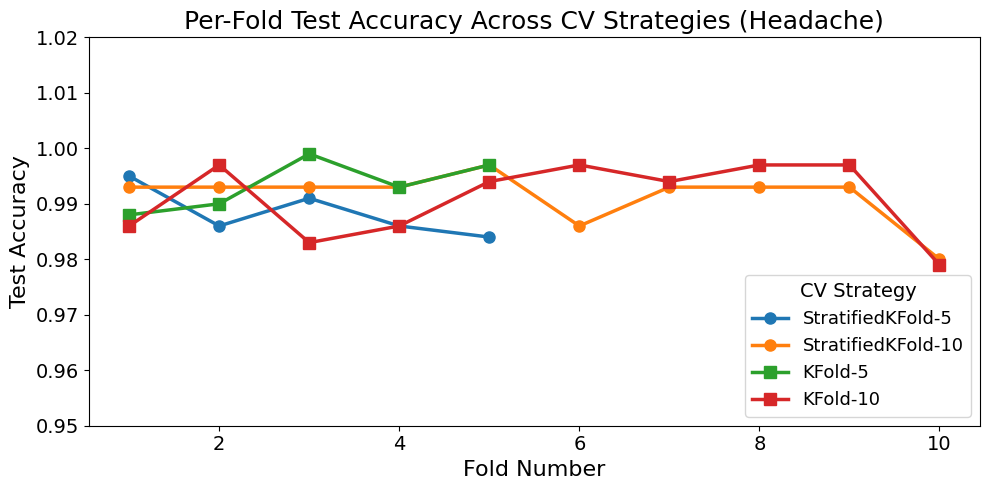

In [ ]:
def extract_fold_accuracies(results):
    return [r['test_acc'] for r in results]

acc_strat_k5 = extract_fold_accuracies(stratified_results_k_5)
acc_strat_k10 = extract_fold_accuracies(stratified_results_k_10)
acc_kfold_k5 = extract_fold_accuracies(kfold_results_k_5)
acc_kfold_k10 = extract_fold_accuracies(kfold_results_k_10)

plt.figure(figsize=(10, 5))

plt.plot(range(1, 6), acc_strat_k5, marker='o', linewidth=2.5, markersize=8, label='StratifiedKFold-5')
plt.plot(range(1, 11), acc_strat_k10, marker='o', linewidth=2.5, markersize=8, label='StratifiedKFold-10')
plt.plot(range(1, 6), acc_kfold_k5, marker='s', linewidth=2.5, markersize=8, label='KFold-5')
plt.plot(range(1, 11), acc_kfold_k10, marker='s', linewidth=2.5, markersize=8, label='KFold-10')

plt.xlabel("Fold Number", fontsize=16)
plt.ylabel("Test Accuracy", fontsize=16)
plt.title("Per-Fold Test Accuracy Across CV Strategies (Headache)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.95, 1.02)

plt.legend(fontsize=13, title="CV Strategy", title_fontsize=14, loc='lower right')

plt.tight_layout()
plt.show()

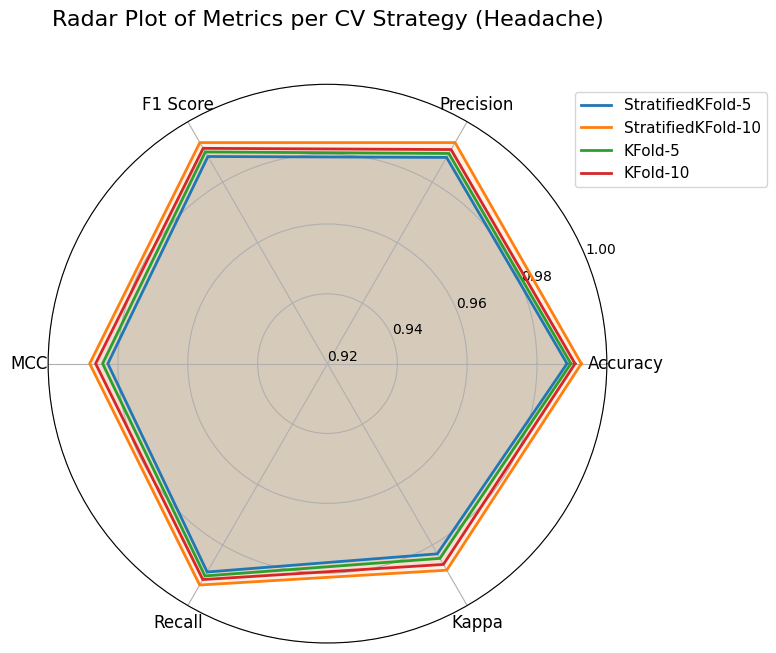

In [ ]:
def get_avg_metrics(results, label):
    metrics = []
    for r in results:
        y_true = np.array(r['y_true'])
        y_pred = np.array(r['y_pred'])
        metrics.append({
            'Accuracy': r['test_acc'],
            'Precision': precision_score(y_true, y_pred, average='macro'),
            'F1 Score': r['test_f1'],
            'MCC': matthews_corrcoef(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred, average='macro'),
            'Kappa': cohen_kappa_score(y_true, y_pred),
        })
    avg = pd.DataFrame(metrics).mean().to_dict()
    avg['Strategy'] = label
    return avg

all_results = [
    get_avg_metrics(stratified_results_k_5, 'StratifiedKFold-5'),
    get_avg_metrics(stratified_results_k_10, 'StratifiedKFold-10'),
    get_avg_metrics(kfold_results_k_5, 'KFold-5'),
    get_avg_metrics(kfold_results_k_10, 'KFold-10')
]

df_radar = pd.DataFrame(all_results)
metrics_cols = ['Accuracy', 'Precision', 'F1 Score', 'MCC', 'Recall', 'Kappa']
min_val = 0.92
max_val = 1.0
df_scaled = df_radar.copy()
df_scaled[metrics_cols] = (df_scaled[metrics_cols] - min_val) / (max_val - min_val)

labels = metrics_cols
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
plt.figure(figsize=(8, 8))

for i in range(len(df_scaled)):
    values = df_scaled.loc[i, labels].tolist()
    values += values[:1]
    plt.polar(angles, values, label=df_scaled['Strategy'][i], linewidth=2)
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], labels, fontsize=12)

yticks_scaled = np.linspace(0, 1.0, 5)
yticks_labels = [f"{min_val + y * (max_val - min_val):.2f}" for y in yticks_scaled]
plt.yticks(yticks_scaled, yticks_labels, fontsize=10)
plt.ylim(0, 1)

plt.title("Radar Plot of Metrics per CV Strategy (Headache)", size=16, y=1.09)
plt.legend(loc='upper right', fontsize=11, bbox_to_anchor=(1.3, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

# **XAI**

# INTRINSIC MODEL INTERPRETATION

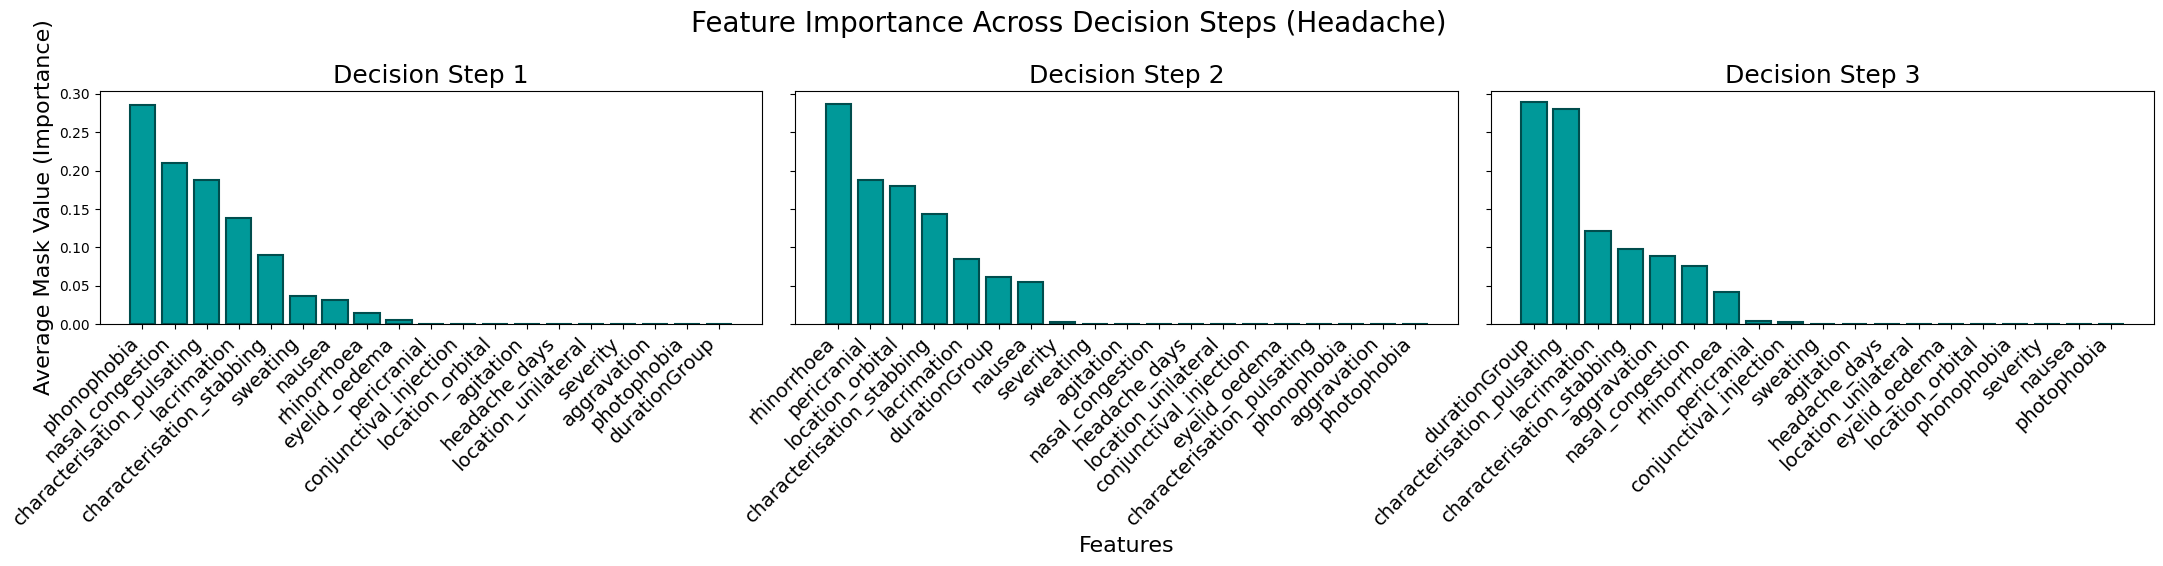

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomTabNetClassifier(
    input_dim=input_dim,
    feature_dim=96,
    n_steps=3,
    gamma=1.3,
    n_glu=2,
    n_shared=2,
    n_independent=2,
    num_classes=3,
    dropout=0.1
).to(device)

checkpoint = torch.load('/content/drive/MyDrive/NeuroTab/Headache/NeuroTab_headache_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def extract_feature_masks(model, data_loader):
    n_steps = model.encoder.n_steps
    input_dim = model.encoder.input_dim
    all_masks = [[] for _ in range(n_steps)]

    model.eval()
    with torch.no_grad():
        for X_batch, _ in data_loader:
            X_batch = X_batch.to(device)
            x_o = model.encoder.bn(X_batch)
            prior = torch.ones_like(x_o)
            initial_output = model.encoder.initial_transform(x_o)
            n_d = model.encoder.feature_dim // 2
            a_prev = initial_output[:, n_d:]

            for i, step in enumerate(model.encoder.decision_steps):
                mask = step.attentive_transformer(a_prev, prior)
                all_masks[i].append(mask.cpu().numpy())
                _, a_i, _, prior = step(a_prev, prior, x_o)
                a_prev = a_i

    avg_masks = []
    for step_masks in all_masks:
        step_masks = np.concatenate(step_masks, axis=0)
        avg_masks.append(np.mean(step_masks, axis=0))

    return np.array(avg_masks)

feature_names = df.drop(columns=["CLASS"]).columns.tolist()
avg_masks = extract_feature_masks(model, test_loader)
fig, axes = plt.subplots(1, 3, figsize=(22, 5.5), sharey=True)
n_steps = avg_masks.shape[0]
for step in range(n_steps):
    sorted_indices = np.argsort(avg_masks[step])[::-1]
    sorted_importance = avg_masks[step][sorted_indices]
    sorted_features = [feature_names[i] for i in sorted_indices]

    axes[step].bar(
        range(len(sorted_features)),
        sorted_importance,
        color="#009999",
        edgecolor='#004d4d',
        linewidth=1.5
    )

    axes[step].set_title(f'Decision Step {step + 1}', fontsize=18)
    if step == 1:
        axes[step].set_xlabel('Features', fontsize=16)
    if step == 0:
        axes[step].set_ylabel('Average Mask Value (Importance)', fontsize=16)

    axes[step].set_xticks(range(len(sorted_features)))
    axes[step].set_xticklabels(
        sorted_features,
        rotation=45,
        ha='right',
        fontsize=14
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle('Feature Importance Across Decision Steps (Headache)', fontsize=20, y=1.02)
plt.subplots_adjust(wspace=0.05)
plt.show()

# EXTRINSIC MODEL INTERPRETATION

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you ha

In [ ]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a99764adfccef0001891c0deec42a346afe2eadf6c9e0761800cd0e749367bb3
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


# **SHAP**

**SHAP: Beeswarm Plots**

PermutationExplainer explainer: 2899it [36:26,  1.33it/s]
/tmp/ipython-input-1855661869.py:30: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 0], X_sample_df, plot_type='dot')


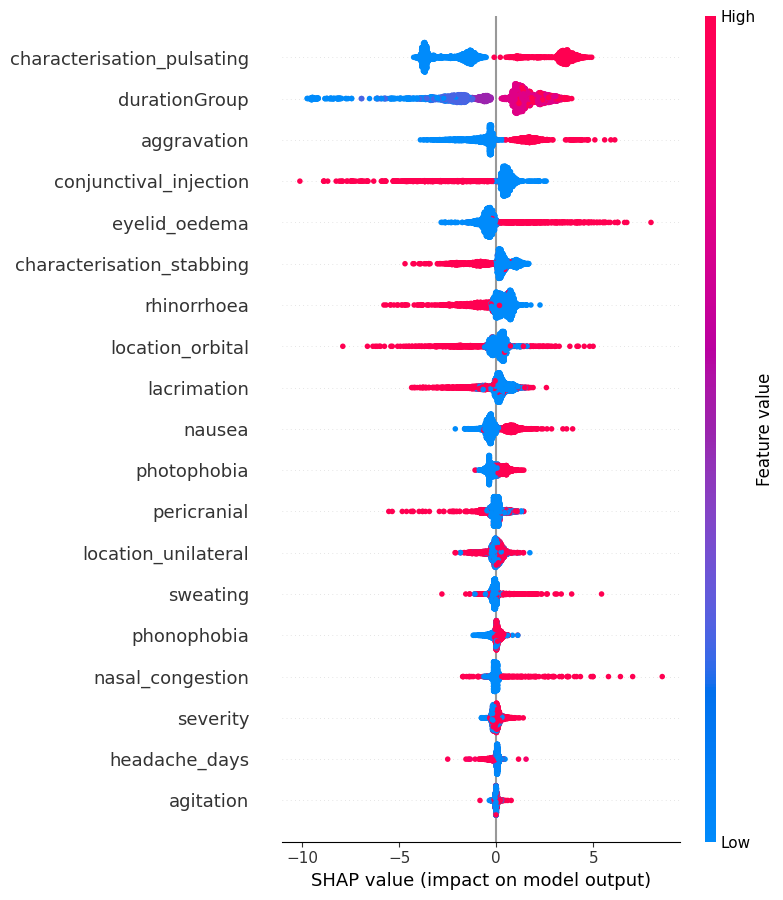

/tmp/ipython-input-1855661869.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_sample_df, plot_type='dot')


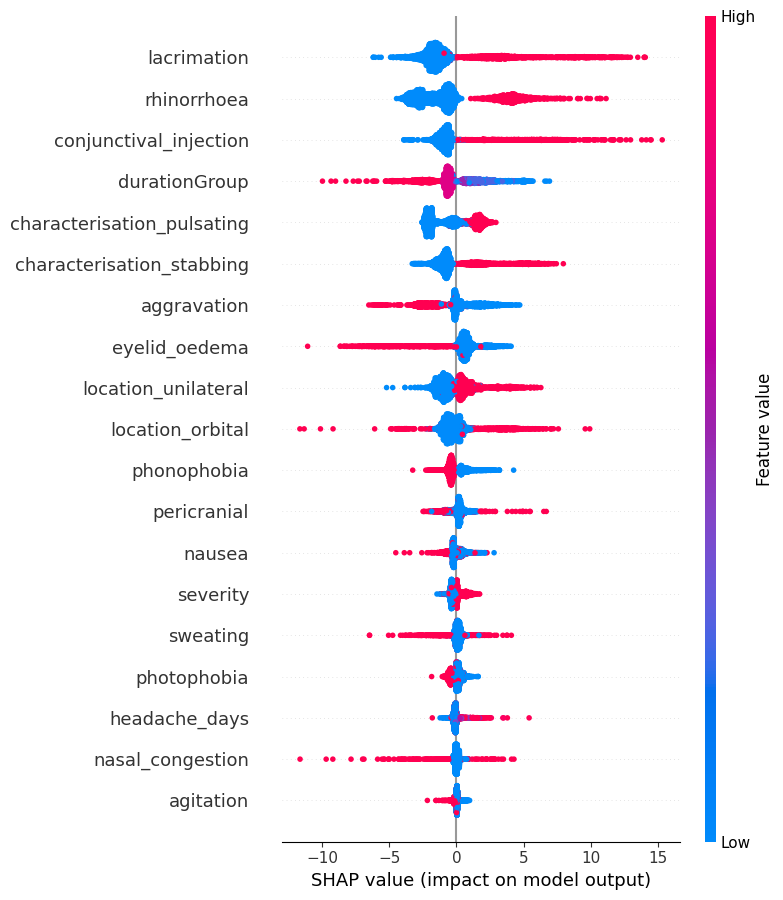

/tmp/ipython-input-1855661869.py:32: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 2], X_sample_df, plot_type='dot')


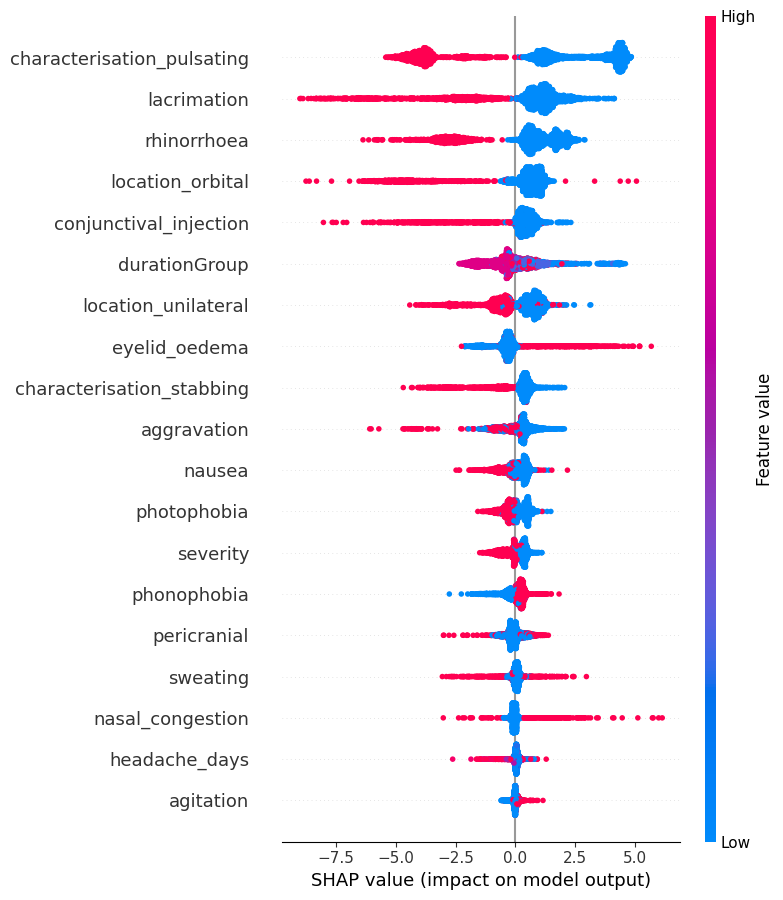

In [ ]:
import shap

X_sample = X_scaled.astype(np.float32)
X_sample_df = pd.DataFrame(X_sample, columns=X.columns)
model.eval()

def model_forward(x_df):
    x_numpy = x_df.values.astype(np.float32)
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
    return logits.cpu().numpy()

explainer = shap.Explainer(model_forward, X_sample_df)

shap_values = explainer(X_sample_df)

shap.summary_plot(shap_values[:, :, 0], X_sample_df, plot_type='dot')
shap.summary_plot(shap_values[:, :, 1], X_sample_df, plot_type='dot')
shap.summary_plot(shap_values[:, :, 2], X_sample_df, plot_type='dot')

**Instance 456: class 0**

**SHAP: Waterfall Plot**

Predicted class: 0


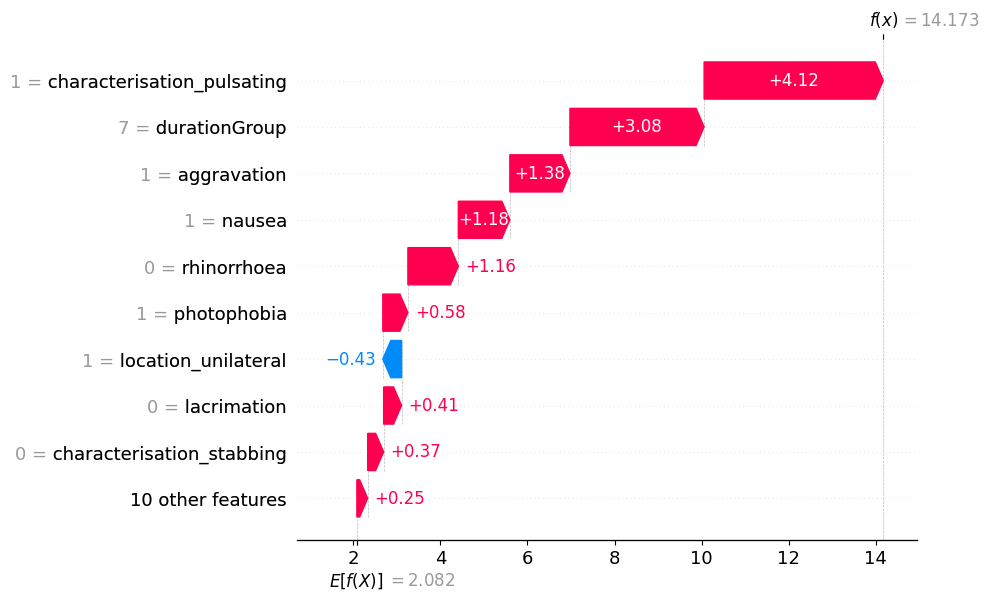

In [ ]:
import shap
sample_idx = 456
X_orig_df = pd.DataFrame(X, columns=X.columns)
X_one_df = pd.DataFrame([X.iloc[sample_idx]], columns=X.columns)

def model_forward_unscaled(x_df):
    x_scaled = scaler.transform(x_df)
    x_tensor = torch.tensor(x_scaled.astype(np.float32)).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
    return logits.cpu().numpy()

explainer = shap.Explainer(model_forward_unscaled, X_orig_df)

shap_values = explainer(X_one_df)
pred_class = np.argmax(model_forward_unscaled(X_one_df))
print(f"Predicted class: {pred_class}")

shap.plots.waterfall(shap_values[0][:, pred_class])

**SHAP: Summary Plot**

PermutationExplainer explainer: 101it [01:29,  1.08it/s]
/tmp/ipython-input-617927334.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type="bar")


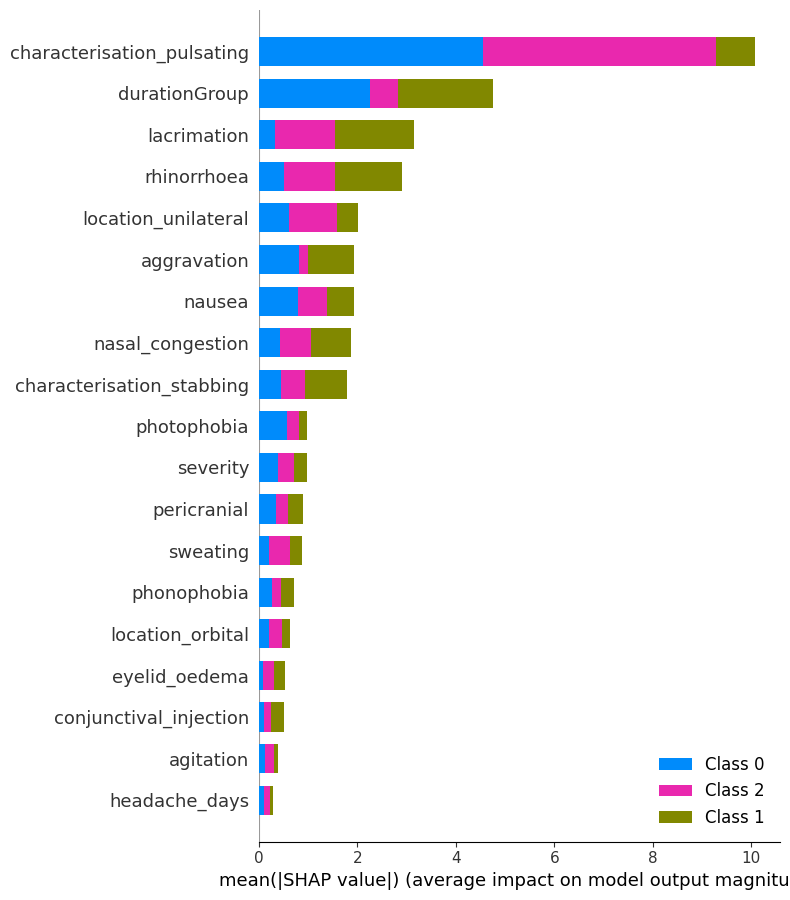

In [ ]:
import shap
X_sample = X_scaled[:100].astype(np.float32)
X_sample_df = pd.DataFrame(X_sample, columns=X.columns)

model.eval()

def model_forward(x_df):
    x_numpy = x_df.values.astype(np.float32)
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
    return logits.cpu().numpy()

explainer = shap.Explainer(model_forward, X_sample_df)

shap_values = explainer(X_sample_df)

X_shap = pd.DataFrame(X_scaled, columns=X.columns)
shap.summary_plot(shap_values, X_shap, plot_type="bar")

**LIME Plots**

Predicted class: 0


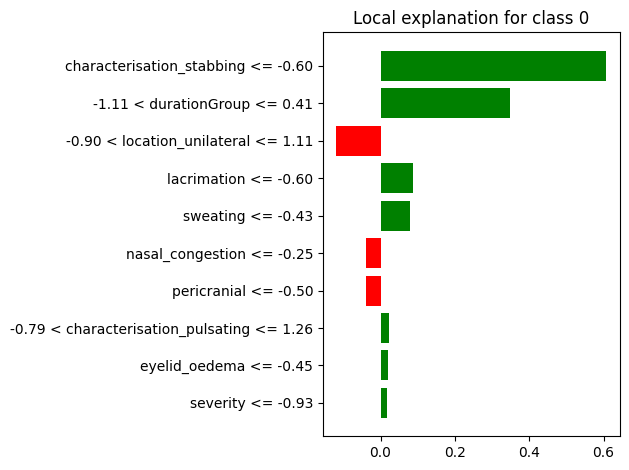

In [ ]:
import lime
import lime.lime_tabular

i = 456
X_np = X_scaled.astype(np.float32)
X_df = pd.DataFrame(X_np, columns=X.columns)
X_instance = X_np[i]
model.eval()

def predict_fn(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

with torch.no_grad():
    instance_tensor = torch.tensor(X_instance.reshape(1, -1), dtype=torch.float32).to(device)
    logits = model(instance_tensor)
    probs = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()

print(f"Predicted class: {predicted_class}")

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_np,
    feature_names=X.columns.tolist(),
    class_names=[str(c) for c in sorted(np.unique(y))],
    mode='classification',
    discretize_continuous=True
)

explanation = explainer.explain_instance(
    data_row=X_instance,
    predict_fn=predict_fn,
    num_features=10,
    labels=[predicted_class]
)

explanation.show_in_notebook(show_table=True, show_all=False)

fig = explanation.as_pyplot_figure(label=predicted_class)
plt.tight_layout()
plt.show()

**Integrated Gradients Plots**

/tmp/ipython-input-1751484101.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  input_tensor = torch.tensor([X_scaled[i]], dtype=torch.float32).to(device)



Instance 456 details:
Predicted class: 0
Class 0 probability: 1.0000
Class 1 probability: 0.0000
Class 2 probability: 0.0000

Class 0 - Convergence delta: -0.019661


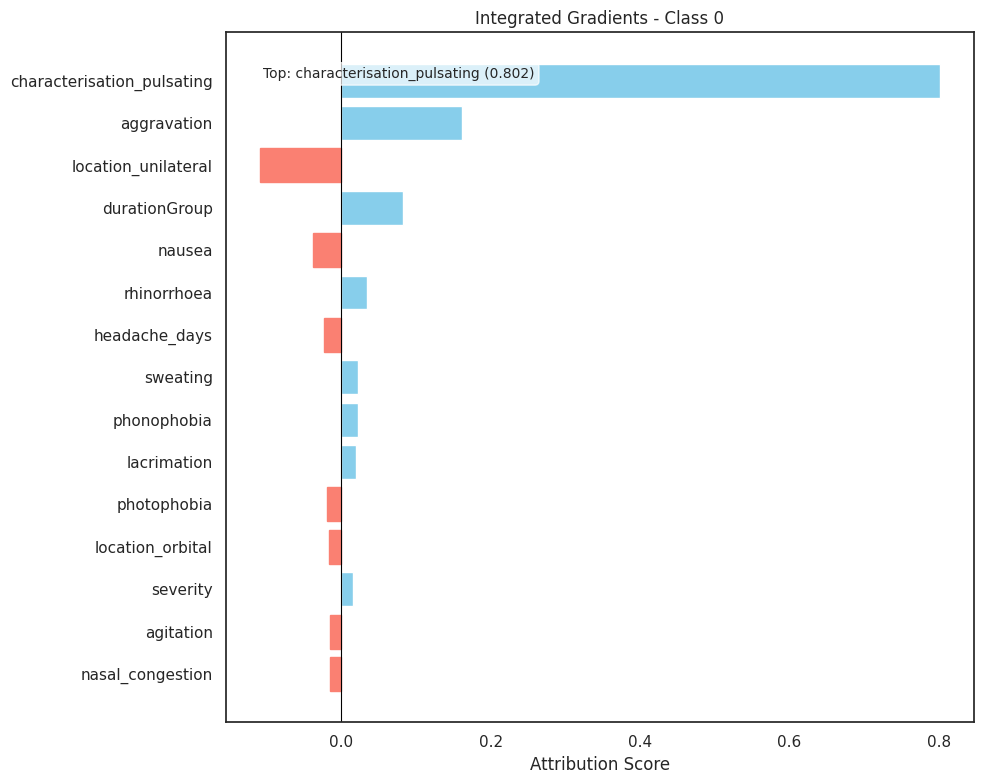


Class 1 - Convergence delta: 0.000026


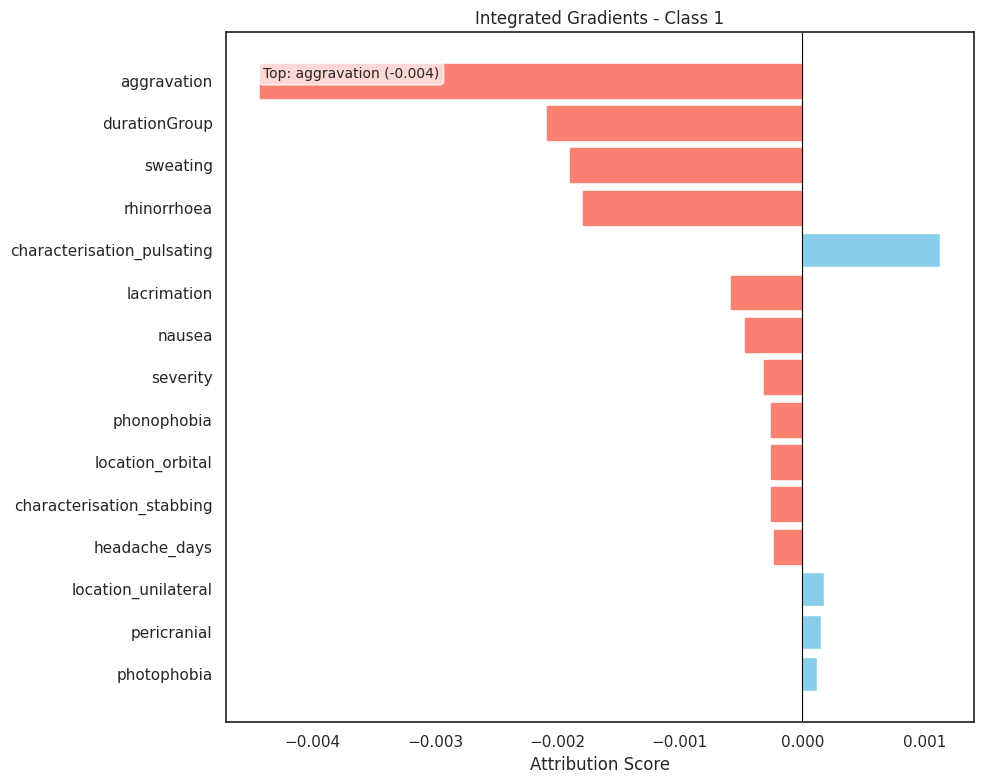


Class 2 - Convergence delta: 0.019635


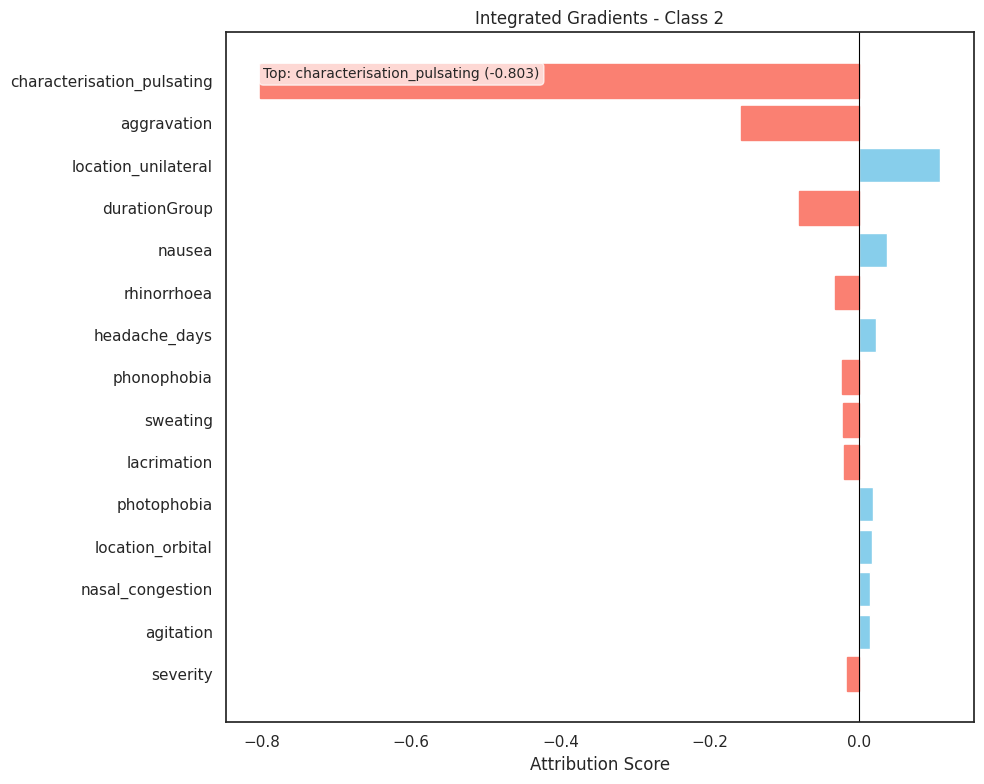


Summary of Top Features by Class:
   Class                                       Top Features  Top Attribution
0      0  characterisation_pulsating, aggravation, locat...         0.801712
1      1  aggravation, durationGroup, sweating, rhinorrh...        -0.004431
2      2  characterisation_pulsating, aggravation, locat...        -0.802838


In [ ]:
from captum.attr import IntegratedGradients

sns.set(style="white")
plt.rcParams.update({'font.size': 12})

i = 456
input_tensor = torch.tensor([X_scaled[i]], dtype=torch.float32).to(device)
baseline_tensor = torch.tensor([X_train.mean(axis=0)], dtype=torch.float32).to(device)
model.eval()

def forward_func(x):
    logits = model(x)
    probs = torch.softmax(logits, dim=1)
    return probs

ig = IntegratedGradients(forward_func)

num_classes = model.head.out_features

with torch.no_grad():
    prediction = model(input_tensor)
    predicted_class = torch.argmax(prediction, dim=1).item()
    probabilities = torch.softmax(prediction, dim=1)[0].cpu().numpy()

print(f"\nInstance {i} details:")
print(f"Predicted class: {predicted_class}")
for class_idx, prob in enumerate(probabilities):
    print(f"Class {class_idx} probability: {prob:.4f}")

for target_class in range(num_classes):
    attributions, delta = ig.attribute(
        inputs=input_tensor,
        baselines=baseline_tensor,
        target=target_class,
        return_convergence_delta=True
    )

    print(f"\nClass {target_class} - Convergence delta: {delta.item():.6f}")

    attributions_np = attributions.squeeze(0).detach().cpu().numpy()

    normalized_attributions = attributions_np / np.sum(np.abs(attributions_np))

    feature_names = X.columns.tolist()

    df_ig = pd.DataFrame({
        'Feature': feature_names,
        'Attribution': attributions_np,
        'Normalized Attribution': normalized_attributions
    }).sort_values(by='Attribution', key=np.abs, ascending=False)

    plt.figure(figsize=(10, 8))

    top_features = 15

    bars = plt.barh(
        df_ig['Feature'][:top_features][::-1],
        df_ig['Attribution'][:top_features][::-1],
        color='skyblue'
    )
    for bar in bars:
        if bar.get_width() < 0:
            bar.set_color('salmon')

    plt.axvline(0, color='black', linewidth=0.8)

    plt.xlabel("Attribution Score")
    plt.title(f"Integrated Gradients - Class {target_class}")

    top_feature = df_ig.iloc[0]['Feature']
    top_attr = df_ig.iloc[0]['Attribution']
    plt.text(0.05, 0.95, f"Top: {top_feature} ({top_attr:.3f})",
            transform=plt.gca().transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    plt.grid(False)
    plt.tight_layout()
    plt.show()

summary_data = []
for target_class in range(num_classes):
    attributions, _ = ig.attribute(
        inputs=input_tensor,
        baselines=baseline_tensor,
        target=target_class,
        return_convergence_delta=True
    )

    attributions_np = attributions.squeeze(0).detach().cpu().numpy()

    df_ig = pd.DataFrame({
        'Feature': feature_names,
        'Attribution': attributions_np
    }).sort_values(by='Attribution', key=np.abs, ascending=False)

    top_features = df_ig.head(5)['Feature'].tolist()
    summary_data.append({
        'Class': target_class,
        'Top Features': ', '.join(top_features),
        'Top Attribution': df_ig.iloc[0]['Attribution']
    })

summary_df = pd.DataFrame(summary_data)
print("\nSummary of Top Features by Class:")
print(summary_df)